## Setting up and preprocessing

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import openpyxl

### Getting SDG definitions

Reading the SDG definition data file. This file is obtained from https://figshare.com/articles/dataset/Keywords_and_search_strings_for_generating_SDG_training_sets/17294255?file=31949768 

It is not the "official definition" of UN SDG, it is a good simple and usable explanation for what each UN SDG is about. 

The below code shows some cleaning done on the raw excel file downloaded from the source, and then save the cleaned data into a file ready to use. 


We need to clean up the extra headers in the excel file.

We can save the cleaned up data for later use.

### Loading text data

* download the data from the source site: https://zenodo.org/records/11441197 , or download from my drive: 

* inspect the csv file and notice that each row is enclosed in double quotes, and the columns are delimited by tab
📘 The file contains 43,0210 (+390) text excerpts and a total of 310,328 (+3,733) assigned labels.

* web site said the file contains 43,0210 (+390) text excerpts and a total of 310,328 (+3,733) assigned labels. We should verify against these to be sure that we have read and processed the data correctly as they were
* we had 43025 rows and 310357 labels instead. Given the difference, we can take the data as read and continue processing.

In [3]:
data_dir = '/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data/'
text_file_name = "osdg-community-data-v2024-04-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43025 entries, 0 to 43024
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   doi              43025 non-null  object 
 1   text_id          43025 non-null  object 
 2   text             43025 non-null  object 
 3   sdg              43025 non-null  int64  
 4   labels_negative  43025 non-null  int64  
 5   labels_positive  43025 non-null  int64  
 6   agreement        43025 non-null  float64
dtypes: float64(1), int64(3), object(3)
memory usage: 2.3+ MB


In [4]:
text_df.labels_negative.sum() + text_df.labels_positive.sum()

310357

In [7]:
text_df.head()

,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,8,0.777778
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,8,0.777778
3,10.1787/3726edff-en,0005d3e8b213d9e2cb967666e1aca2e9,Applied research is directed “primarily toward...,9,3,6,0.333333
4,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3,1,2,0.333333


### Cleaning and filtering data
* drop the columns not needed: the first column contains the DOI of the text excerpt, not needed for our purpose.
* filter the rows: we want to use those text excerpts that have labeling agreement greater than 0.5 and the number of positive label is greater than negative label by more than 2.
* after such cleaning, we have 26,526 rows of data.


In [8]:
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2").reset_index(drop=True)
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26526 entries, 0 to 26525
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text_id          26526 non-null  object 
 1   text             26526 non-null  object 
 2   sdg              26526 non-null  int64  
 3   labels_negative  26526 non-null  int64  
 4   labels_positive  26526 non-null  int64  
 5   agreement        26526 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 1.2+ MB


### Loading NLTK data as examples

NLTK comes with some books as text example.

In [9]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /Users/yingli/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /Users/yingli/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /Users/yingli/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /Users/yingli/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /Users/yingli/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /Users/yingli/nltk_data...
[nltk_data]    |   Package movie_reviews is already

True

In [10]:
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [11]:
print(text9[100:120])

['that', 'lit', 'our', 'aimless', 'gloom', ',', 'Men', 'showed', 'their', 'own', 'white', 'feather', 'as', 'proudly', 'as', 'a', 'plume', '.', 'Life', 'was']


## NLP preprocessing

### Handling languages and cases in the text

There exists many packages for detecting languages in the text. "langdetect" is easy to use and very much a single purposed, it is also a bit old (dated last update) but still functional.

In [12]:
from langdetect import detect
print(detect("War doesn't show who's right, just who's left."))
print(detect("Ein, zwei, drei, vier"))
print(detect('四个和尚没水喝'))
print(detect('今一はお前さん'))

en
de
zh-cn
ja


We add a column in data frame for the corresponding language.

In [13]:
from langdetect import detect
text_df["lang"] = text_df.loc[:,"text"].apply(lambda x: detect(x)).to_list()
text_df.lang.value_counts()

lang
en    26471
fr       45
es        6
de        1
et        1
fi        1
id        1
Name: count, dtype: int64

Should we filter out those non-english texts?

* Depending on the tasks, we may get "wrong" results, or it may not matter as much. Most important is to ensure a text does not break the code. 
* a body of text may not be of a single language, could be mixed in with phrases of multiple languages. As we see in below, row 19351 in our cleaned data frame has chinese mixed in among english.
* however, detecting language is still important for some tasks such as word breaking, stemming, stop-word removal, etc. 

In [14]:
text_df.query("lang== 'fr'")["text"]

161      Une telle decomposition par categorie UICN n'e...
624      Le papier discute ensuite les choix methodolog...
1480     Revenant aux reorientations plus recentes de f...
1669     Les problemes de sante mentale legers a modere...
3384     Cependant, le developpement de mecanismes de r...
5400     Par contre, on n’aper^oit pas une difference c...
6069     Moreover, a budget-neutral redistribution of f...
6662     Il existe une raison supplementaire pour mettr...
6793     Ce document est le premier a donner une vue d’...
7701     A cette fin, il est divise en trois sections. ...
7925     Les taux d’emploi feminins reagissent aux vari...
8172     The emphasis is on understanding how increasin...
9277     Entre 2007 et 2012, le niveau de vie median de...
9321     Enfin, il analyse, a partir des Statistiques d...
9445     This paper looks at the features of good caree...
10095    La mise en oeuvre de l'enquete se fait de mani...
10328    Ces donnees montrent que le niveau global des .

Use str.find to locate the position of a substring in a string, negative return indicate not found.

Use of lower() and casefold()

In [15]:
text_df[text_df["text"].apply(lambda x: x.find('四个全面')) > 0]["text"]

19351    In China today,President Xi Jinping’s new gran...
Name: text, dtype: object

In [16]:
print(text_df[text_df["text"].apply(lambda x: x.find('四个全面')) > 0]["text"].values[0])

In China today,President Xi Jinping’s new grand narrative is framed by the widely publicised ‘four comprehensives’ (四个全面, ‘sigequanmian’). This narrative aims to : 1.build a moderately prosperous society, 2. deepen reform, 3. govern the nation according to law, and 4. tighten Party discipline. It is essentially a political narrative that tells a moral tale that legitimizes and glorifies the virtues of the present. It also attempts to shrug off mistakes of the previous dynasty. Drawing on the legal disciplines of economic law, international comparative law and the a priori analytic method of legal narrative analysis, this paper provides a critical appraisal of the ‘four comprehensives’, paying special attention to how the four principal strands of the narrative shape the directions of China’s socialist rule of law reforms and governance.  Key words: Chinese law reform, four comprehensives, 四个全面, sigequanmian,socialist rule of law,legal narrative analysis, economic-law nexus, South China

In [17]:
temp_text = text_df[text_df["text"].apply(lambda x: x.find('四个全面')) > 0]["text"].values[0]
print(temp_text == text_df.iloc[19351].text)
print(temp_text is text_df.iloc[19351].text)
print(temp_text == text_df.iloc[19351].text.casefold())
print(temp_text.lower() == text_df.iloc[19351].text.casefold())

True
True
False
True


In [18]:
print(temp_text.casefold())

in china today,president xi jinping’s new grand narrative is framed by the widely publicised ‘four comprehensives’ (四个全面, ‘sigequanmian’). this narrative aims to : 1.build a moderately prosperous society, 2. deepen reform, 3. govern the nation according to law, and 4. tighten party discipline. it is essentially a political narrative that tells a moral tale that legitimizes and glorifies the virtues of the present. it also attempts to shrug off mistakes of the previous dynasty. drawing on the legal disciplines of economic law, international comparative law and the a priori analytic method of legal narrative analysis, this paper provides a critical appraisal of the ‘four comprehensives’, paying special attention to how the four principal strands of the narrative shape the directions of china’s socialist rule of law reforms and governance.  key words: chinese law reform, four comprehensives, 四个全面, sigequanmian,socialist rule of law,legal narrative analysis, economic-law nexus, south china

In [19]:
text = 'groß'

# convert text to lowercase using casefold()
print('Using casefold():', text.casefold()) 

# convert text to lowercase using lower()
print('Using lower():', text.lower())

Using casefold(): gross
Using lower(): groß


In [20]:
text_df.iloc[3].text.lower()

'the israel oceanographic and limnological research station monitors the quantity and quality of water along the coastline of the mediterranean sea. the nature and parks authority (npa) monitors water quality in rivers on behalf of the moep. mekorot and local authorities monitor drinking water quality under the supervision of the ministry of health. the ministry of health monitors effluent quality prior to its use in the agricultural sector.'

 - use fasttext to detect language
 - it can return top k languages with the estimated probability

In [21]:
import fasttext
temp_text = text_df[text_df["text"].apply(lambda x: x.find('四个全面')) > 0]["text"].values[0]

model = fasttext.load_model(data_dir + 'lid.176.ftz')
print(model.predict(temp_text, k=3))
print(model.predict("In China today,President Xi Jinping’s new grand narrative is framed by the widely publicised ‘four comprehensives’ (四个全面, ‘sigequanmian’)."))
print(model.predict('四个全面', k=3))
print(model.predict('الشمس تشرق', k=2))  # top 2 matching languages
print(model.predict("影響包含對氣候的變化以及自然資源的枯竭程度",k=2))  # top 2 matching languages


(('__label__en', '__label__fr', '__label__es'), array([0.87778687, 0.00653897, 0.00630662]))
(('__label__en',), array([0.84054285]))
(('__label__zh', '__label__ja'), array([0.68349081, 0.31656581]))
(('__label__ar', '__label__fa'), array([0.98124713, 0.01265871]))
(('__label__zh', '__label__fr'), array([9.99575794e-01, 2.11721170e-04]))


### Stemming

In [22]:
from nltk import stem

tokens =  ['narrative', 'comprehensives', 'publicised', 'moderately', 'prosperous', 'legitimizes', 'according', 'glorifies'] 

porter = stem.porter.PorterStemmer() # Porter stemmer
snowball = stem.snowball.EnglishStemmer() # Snowball stemmer
lancaster = stem.lancaster.LancasterStemmer() # Lancaster stemmer

print('Porter Stemmer:', [porter.stem(i) for i in tokens])
print('Snowball Stemmer:', [snowball.stem(i) for i in tokens])
print('Lancaster Stemmer:', [lancaster.stem(i) for i in tokens])


Porter Stemmer: ['narr', 'comprehens', 'publicis', 'moder', 'prosper', 'legitim', 'accord', 'glorifi']
Snowball Stemmer: ['narrat', 'comprehens', 'publicis', 'moder', 'prosper', 'legitim', 'accord', 'glorifi']
Lancaster Stemmer: ['nar', 'comprehend', 'publ', 'mod', 'prosp', 'legitim', 'accord', 'glor']


### build vocabulary and compute frequency

NLTK corpus are already pre-processed, came with vocabulary and frequencies.

In [23]:
text9.vocab()

FreqDist({',': 3488, 'the': 3291, '.': 2717, 'a': 1713, 'of': 1710, 'and': 1568, '"': 1336, 'to': 1045, 'in': 888, 'I': 885, ...})

look at the top 30 tokens in terms frequency (appearance counts in the text), and plot their accumulative totals

   ,  the    .    a   of  and    "   to   in    I   he that  his  was  you   it with Syme   ," said    '   is   as  had   ."  not    ;  The   at    - 
3488 3291 2717 1713 1710 1568 1336 1045  888  885  858  841  765  716  580  565  544  515  507  507  496  462  456  427  391  355  331  326  324  294 
None


<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

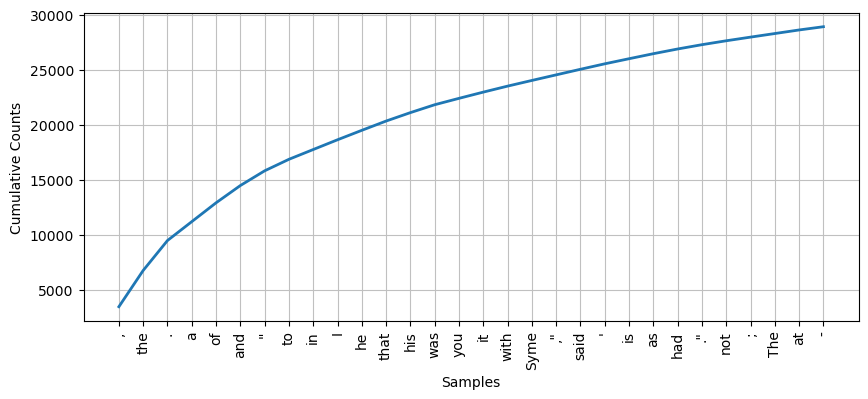

In [24]:
print(text9.vocab().tabulate(30))
plt.figure(figsize = (10,4))
text9.vocab().plot(30, cumulative=True)

### NLP prrocessing using NLTK

In [25]:
import re
from nltk.util import ngrams # function for making ngrams

In [26]:
temp_text = text_df[text_df["text"].apply(lambda x: x.find('四个全面')) > 0]["text"].values[0]
print(temp_text)
print(temp_text.split())

In China today,President Xi Jinping’s new grand narrative is framed by the widely publicised ‘four comprehensives’ (四个全面, ‘sigequanmian’). This narrative aims to : 1.build a moderately prosperous society, 2. deepen reform, 3. govern the nation according to law, and 4. tighten Party discipline. It is essentially a political narrative that tells a moral tale that legitimizes and glorifies the virtues of the present. It also attempts to shrug off mistakes of the previous dynasty. Drawing on the legal disciplines of economic law, international comparative law and the a priori analytic method of legal narrative analysis, this paper provides a critical appraisal of the ‘four comprehensives’, paying special attention to how the four principal strands of the narrative shape the directions of China’s socialist rule of law reforms and governance.  Key words: Chinese law reform, four comprehensives, 四个全面, sigequanmian,socialist rule of law,legal narrative analysis, economic-law nexus, South China

In [27]:
print(re.search(r'China', temp_text))
print(re.search(r'[a-z]\,',temp_text)) # searching for the first lower case letter followed by a comma. 


<re.Match object; span=(3, 8), match='China'>
<re.Match object; span=(13, 15), match='y,'>


breaking text into sentences and words (tokens).

In [40]:
from nltk import word_tokenize, sent_tokenize
nltk.download('punkt_tab') 
corpus = text_df.text
corpus_str = corpus.str.cat() 
tokens = word_tokenize(corpus_str)
len(tokens), len(set(tokens))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yingli/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


(2804995, 88421)

In [29]:
print(tokens[100:130])

['represents', 'continuity', 'with', 'the', 'past', "''", '(', 'Paulgaard', '2002', ':', '102', ')', '.', 'When', 'Paulgaard', 'refers', 'to', 'continuity', 'with', 'traditions', ',', 'she', 'refers', 'to', 'the', 'expectations', 'of', 'young', 'adults', 'to']


In [30]:
from nltk import collocations
fd = collocations.FreqDist(tokens)
fd.most_common(30)

[(',', 140392),
 ('the', 135380),
 ('of', 101802),
 ('and', 99508),
 ('.', 72493),
 ('to', 68025),
 ('in', 63195),
 ('a', 35385),
 ('for', 29778),
 ('(', 28134),
 (')', 27107),
 ('is', 26909),
 ('that', 21493),
 ('are', 19506),
 ('on', 18912),
 ('as', 18416),
 ('with', 14674),
 ('by', 14569),
 ('be', 13463),
 ('The', 13080),
 ('from', 10226),
 ('have', 9767),
 ('or', 9650),
 ('has', 8096),
 ('not', 8009),
 ('this', 7928),
 ('countries', 7910),
 ('an', 7890),
 ('their', 7621),
 ('also', 7530)]

In [31]:
measures = collocations.BigramAssocMeasures()
c = collocations.BigramCollocationFinder.from_words(tokens)
c.nbest(measures.pmi,100)

[("'Camikavas", 'negi'),
 ("'Necessary", 'Thickening'),
 ("'PES-like", "fashion'and"),
 ("'Paris", "rulebook'.This"),
 ("'any", 'electrically'),
 ("'ex", 'turpi'),
 ("'family", "values'.To"),
 ("'nine", 'gems'),
 ("'opportunity", "cost'approach"),
 ('-16.58', 'p.p.'),
 ('-Midia', 'Navodari'),
 ('-at', 'times-also'),
 ('-chronically-ill', 'people-'),
 ('-red', 'ressing'),
 ('.95.5', '95.3'),
 ('.Case', 'Closed'),
 ('.Definiciones', 'Instrumentos'),
 ('.Resolution', '49/116'),
 ('//climatepolicyinitiative.org/', 'wp-content/uploads/2015/05/150512'),
 ('//data.uJorldbank.org/', 'about/country-classifications'),
 ('//documents.worldbank.org/curated/en/552891468229171088/Cambodia-Nutrition-at-a-g',
  'lance'),
 ('//documents.worldbank.org/curated/en/822981493749732711/',
  'Enabling-the-digital-revolution-in-Sub-Saharan-Africa-what-role-for-policy-reforms'),
 ('//doi.org/10.1080/', '07900627.2017.1401919'),
 ('//dx.doi.org/10.1787/', 'sti_scoreboard-2013-en'),
 ('//ec.euroDa.cu/soc', 'ial/B

In [32]:
measures

### Using wordnet

http://wordnetweb.princeton.edu/perl/webwn?s=good&sub=Search+WordNet&o2=&o0=1&o8=1&o1=1&o7=&o5=&o9=&o6=&o3=&o4=&h=


In [38]:
from nltk.corpus import wordnet
wordnet.synsets('study'),wordnet.synsets('study', pos=wordnet.VERB)

([Synset('survey.n.01'),
  Synset('study.n.02'),
  Synset('report.n.01'),
  Synset('study.n.04'),
  Synset('study.n.05'),
  Synset('discipline.n.01'),
  Synset('sketch.n.01'),
  Synset('cogitation.n.02'),
  Synset('study.n.09'),
  Synset('study.n.10'),
  Synset('analyze.v.01'),
  Synset('study.v.02'),
  Synset('study.v.03'),
  Synset('learn.v.04'),
  Synset('study.v.05'),
  Synset('study.v.06')],
 [Synset('analyze.v.01'),
  Synset('study.v.02'),
  Synset('study.v.03'),
  Synset('learn.v.04'),
  Synset('study.v.05'),
  Synset('study.v.06')])

In [39]:
wordnet.synsets('dog'),wordnet.synsets('dog', pos=wordnet.VERB)

([Synset('dog.n.01'),
  Synset('frump.n.01'),
  Synset('dog.n.03'),
  Synset('cad.n.01'),
  Synset('frank.n.02'),
  Synset('pawl.n.01'),
  Synset('andiron.n.01'),
  Synset('chase.v.01')],
 [Synset('chase.v.01')])

In [34]:
synonyms = []
antonyms = []

for syn in wordnet.synsets("good"):
    for l in syn.lemmas():
        synonyms.append(l.name())
        if l.antonyms():
            antonyms.append(l.antonyms()[0].name())

print(set(synonyms))
print(set(antonyms))

{'ripe', 'in_effect', 'soundly', 'expert', 'upright', 'estimable', 'adept', 'well', 'salutary', 'dear', 'dependable', 'safe', 'right', 'undecomposed', 'near', 'unspoilt', 'just', 'trade_good', 'skillful', 'unspoiled', 'serious', 'skilful', 'proficient', 'in_force', 'beneficial', 'secure', 'sound', 'thoroughly', 'full', 'commodity', 'practiced', 'effective', 'honest', 'respectable', 'good', 'goodness', 'honorable'}
{'evil', 'ill', 'badness', 'bad', 'evilness'}


examples of word usage of "good"

In [35]:
wordnet.synsets("good")[0].examples()

['for your own good', "what's the good of worrying?"]

Similarity betwwen words

In [36]:
w1 = wordnet.synset('ship.n.01')
w2 = wordnet.synset('boat.n.01')
w3 = wordnet.synset('car.n.01')
w4 = wordnet.synset('cat.n.01')
print(w1.wup_similarity(w2))
print(w1.wup_similarity(w3))
print(w1.wup_similarity(w4))
print(w2.wup_similarity(w3))
print(w2.wup_similarity(w4))
print(w3.wup_similarity(w4))

0.9090909090909091
0.6956521739130435
0.32
0.6956521739130435
0.32
0.32


In [37]:
#string operations
temp='start'
print(temp.startswith('S'))
print('w' in temp)
print('a' in temp)

False
False
True
